<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/univariate_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlxtend --upgrade

In [450]:
!pip install vaderSentiment

     |████████████████████████████████| 133kB 13.0MB/s 


In [451]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')


from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Financial Phrase Bank 

In [3]:
fin_data = pd.read_table('/content/Sentences_50Agree.txt', delimiter='\r\n')

In [4]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [5]:
data.head(2)

,sentence,sentiment
0,Technopolis plans to develop in stages an area...,neutral
1,The international electronic industry company ...,negative


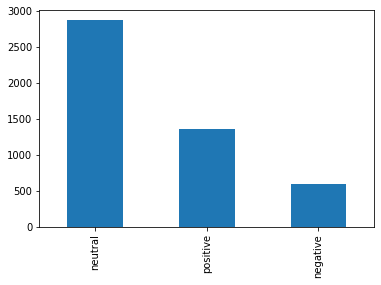

In [6]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [7]:
X= data.sentence
y = data.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60, test_size=0.2)

In [8]:
X_train.shape, X_test.shape, X.shape

((3876,), (969,), (4845,))

In [9]:
neu_index = y_train[y_train == 'neutral'].index
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [10]:

# Down-sample neutral class
X_train_neu, y_train_neu = resample(X_train.loc[neu_index], y_train.loc[neu_index],
                                    n_samples=len(pos_index), replace=False,
                                    random_state=60)

# Up-sample negative class
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index],
                                    n_samples=len(pos_index), replace=True,
                                    random_state=60)

In [11]:
# Combine resampled classes
X_train_resample = X_train.loc[pos_index].append([X_train_neu, X_train_neg])
y_train_resample = y_train.loc[pos_index].append([y_train_neu, y_train_neg])

# Shuffle samples
X_train_resample, y_train_resample = shuffle(X_train_resample, y_train_resample, random_state=7)

# Display new class counts
print(y_train_resample.value_counts())

neutral     1090
negative    1090
positive    1090
Name: sentiment, dtype: int64


# Prepare Data for model

In [12]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_resample)
X_train_seq = tokenizer.texts_to_sequences(X_train_resample)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Make sequences of equal length 
max_len = np.max([len(X_train_seq[i]) for i in range(len(X_train_seq))])
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [14]:
max_len

71

In [15]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train_seq = to_categorical(le.transform(y_train_resample))
y_test_seq = to_categorical(le.transform(y_test))

# EMBEDDINGS

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-03-19 03:07:52--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-19 03:07:52--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-19 03:07:53--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
dict_w2v = {}
with open('/content/glove.6B.100d.txt', 'r') as file:
    for line in file:
        tokens = line.split()
        word = tokens[0]
        vector = np.array(tokens[1:], dtype=np.float32)
        if vector.shape[0] == 100:
            dict_w2v[word] = vector
        else:
            print("There is issue with " + word)

In [20]:
print("dictionary size :" ,len(dict_w2v) )

dictionary size : 400000


In [21]:
words_found = set()
words_not_found = set()
for word in tokenizer.word_index:
    vec = dict_w2v.get(word)
    if vec is not None:
        words_found.add(word)
    else:
        words_not_found.add(word)
len(words_found), len(words_not_found), len(tokenizer.word_index)

(6187, 918, 7105)

In [22]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)
embedding_matrix = np.zeros((VOCAB_SIZE +1, EMBEDDING_DIM))

In [23]:
unk_cnt = 0
unk_set = set()
for word, i in tokenizer.word_index.items():
    emb_vector = dict_w2v.get(word)
    if emb_vector is not None:
        embedding_matrix[i] = emb_vector
    else:
        unk_cnt += 1
        unk_set.add(word)
unk_cnt

918

In [24]:
X_train_seq.shape, y_train_seq.shape

((3270, 71), (3270, 3))

Epoch 1/15
52/52 [==============================] - 5s 37ms/step - loss: 1.0829 - recall: 0.2205 - val_loss: 0.8301 - val_recall: 0.4396
Epoch 2/15
52/52 [==============================] - 1s 22ms/step - loss: 0.8875 - recall: 0.4458 - val_loss: 0.8684 - val_recall: 0.3932
Epoch 3/15
52/52 [==============================] - 1s 22ms/step - loss: 0.7417 - recall: 0.5943 - val_loss: 0.9593 - val_recall: 0.4923
Epoch 4/15
52/52 [==============================] - 1s 22ms/step - loss: 0.6309 - recall: 0.6939 - val_loss: 0.6253 - val_recall: 0.7141
Epoch 5/15
52/52 [==============================] - 1s 22ms/step - loss: 0.5403 - recall: 0.7443 - val_loss: 0.6601 - val_recall: 0.6904
Epoch 6/15
52/52 [==============================] - 1s 23ms/step - loss: 0.4487 - recall: 0.7948 - val_loss: 0.6118 - val_recall: 0.7358
Epoch 7/15
52/52 [==============================] - 1s 22ms/step - loss: 0.3714 - recall: 0.8430 - val_loss: 0.5765 - val_recall: 0.7482
Epoch 8/15
52/52 [=======================

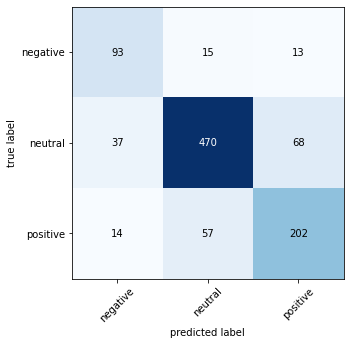

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.646     0.769       0.702        121
neutral         0.867     0.817       0.842        575
positive        0.714     0.740       0.727        273


In [146]:
np.random.seed(60)
model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_len, trainable=True))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat')) #{"sum", "mul", "ave", "concat", None}
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=[ 
                                                                            #  'Precision', 
                                                                             'Recall', 
                                                                            #  'accuracy'
                                                                             ])
# model.summary()

batch_size = 64
epochs = 15

model.fit(X_train_seq, y_train_seq,validation_data=(X_test_seq, y_test_seq), 
          batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True)

preds = model.predict(X_test_seq, batch_size=batch_size)
true_y = np.argmax(y_test_seq, axis=1)
pred_y = np.argmax(preds, axis=1)

c_mat = confusion_matrix(true_y, pred_y)
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

p, r, f1, s = precision_recall_fscore_support(true_y, pred_y, average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

# Prepare NEPSE DATA

In [452]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [453]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)

In [454]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)

In [455]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)

In [456]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)
indices['target'] = np.where(indices['pct_change'] < 0 , 0, 1)

In [457]:
news_df = news_df[['date', 'content']]

In [459]:
indices = indices[['date','index']]

In [460]:
df = pd.merge(news_df, indices, left_on='date', right_on='date')

In [591]:
df

,date,content,index,compound
0,2014-02-02,Nepal Stock Exchange (Nepse) slid 2.22 points ...,775.92,0.0000
1,2014-02-02,Moffat Nyirenda is president of Round Table In...,775.92,0.0000
2,2014-02-02,The government has stopped monitoring of shops...,775.92,-0.2263
3,2014-02-02,The Ministry of Industry (MoI) is preparing to...,775.92,0.3612
4,2014-02-02,The delivery of Chinese aircraft for Nepal Air...,775.92,-0.2263
...,...,...,...,...
6302,2019-06-30,Importers are being allowed to haul the goods ...,"1,244.89",0.0000
6303,2019-06-30,It will be first facility of its kind in the K...,"1,244.89",0.6486
6304,2019-06-30,"Readymade garment, apple, footwear, bags and s...","1,244.89",0.0000
6305,2019-06-30,Domestic supply has helped keep prices stable ...,"1,244.89",0.1531


In [592]:
analyser = SentimentIntensityAnalyzer()

In [700]:
compound_scores = []
for i in df['content']:
   compound_scores.append(analyser.polarity_scores(i)['compound'])

In [701]:
df['compound'] = compound_scores

In [702]:
indices['compound'] = df.groupby('date')['compound'].apply(np.mean).values


In [703]:
# indices['index'] = indices['index'].str.replace(',', '')

In [ ]:
# df.to_csv('indices-news-merged.csv', index=False)
# news_df.to_csv('news-cleaned.csv', index=False)
# indices.to_csv('indices-cleaned.csv', index=False)

In [704]:
indices['index'] = indices['index'].astype('float')

In [705]:
train_df = indices[indices['date'] <= '2017-12-31']
validation_df = indices[(indices['date'] > '2017-12-31') & (indices['date'] <= '2018-12-31')]
test_df = indices[indices['date'] > '2018-12-31']

In [706]:
train_df['compound'] = train_df['compound'].round(2)
validation_df['compound'] = validation_df['compound'].round(2)
test_df['compound'] = test_df['compound'].round(2)

In [662]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

In [678]:
def create_dataset(dataset, scoreset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		b = scoreset[i+look_back-1]
		dataX.append(np.append(a,b))
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [675]:
training_set_scaled = sc.fit_transform(train_df['index'].values.reshape(-1, 1))
cv_set_scaled = sc.transform(validation_df['index'].values.reshape(-1, 1))
test_set_scaled = sc.transform(test_df['index'].values.reshape(-1, 1))

In [607]:
test_set_scaled.shape

(121, 1)

In [608]:
sc1 = MinMaxScaler()
training_score_scaled = sc1.fit_transform(train_df['compound'].values.reshape(-1, 1))
cv_score_scaled = sc1.transform(validation_df['compound'].values.reshape(-1, 1))
test_score_scaled = sc1.transform(test_df['compound'].values.reshape(-1, 1))

In [709]:
train_df

,date,index,compound
0,2014-02-02,775.92,-0.02
1,2014-02-03,769.51,0.19
2,2014-02-04,774.91,0.23
3,2014-02-05,781.38,-0.09
4,2014-02-06,785.78,0.09
...,...,...,...
876,2017-12-24,1467.68,-0.01
877,2017-12-26,1447.04,0.21
878,2017-12-27,1425.51,0.31
879,2017-12-28,1414.78,0.14


In [707]:
trainX, trainY = create_dataset(train_df['index'].values.reshape(-1, 1), train_df['compound'].values.reshape(-1, 1),5)
cvX, cvY = create_dataset(validation_df['index'].values.reshape(-1, 1), validation_df['compound'].values.reshape(-1, 1), 5)
testX, testY = create_dataset(test_df['index'].values.reshape(-1, 1), test_df['compound'].values.reshape(-1, 1), 5)

In [708]:
for i, j in zip(trainX[:5], trainY[:5]):
    print(i, j)

[7.7592e+02 7.6951e+02 7.7491e+02 7.8138e+02 7.8578e+02 9.0000e-02] 784.0
[7.6951e+02 7.7491e+02 7.8138e+02 7.8578e+02 7.8400e+02 3.9000e-01] 803.13
[7.7491e+02 7.8138e+02 7.8578e+02 7.8400e+02 8.0313e+02 1.0000e-02] 796.55
[7.8138e+02 7.8578e+02 7.8400e+02 8.0313e+02 7.9655e+02 3.2000e-01] 798.33
[ 7.8578e+02  7.8400e+02  8.0313e+02  7.9655e+02  7.9833e+02 -1.1000e-01] 803.1


In [683]:
train_df.dtypes

date        datetime64[ns]
index              float64
compound           float64
dtype: object

In [649]:
trainX.shape, cvX.shape, testX.shape

((850, 31), (205, 31), (90, 31))

In [650]:
trainX, trainY = np.array(trainX), np.array(trainY)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

cvX, cvY = np.array(cvX), np.array(cvY)
cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], 1))

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainX.shape, cvX.shape, testX.shape

((850, 31, 1), (205, 31, 1), (90, 31, 1))

In [651]:
import tensorflow.keras.backend as K
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [652]:
import keras
model = Sequential()

model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (trainX.shape[1], 1), unroll = True))

# Adding the output layer
model.add(Dense(1, name="output_layer"))

# Compiling the RNN
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss = root_mean_squared_error)

#Using Tensorboard


# Fitting the RNN to the Training set
model.fit(trainX, trainY, epochs = 30, batch_size = 64,  validation_data = (cvX, cvY))

Epoch 1/30
14/14 [==============================] - 4s 61ms/step - loss: 0.3678 - val_loss: 0.1739
Epoch 2/30
14/14 [==============================] - 0s 17ms/step - loss: 0.1313 - val_loss: 0.0346
Epoch 3/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0502 - val_loss: 0.0605
Epoch 4/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0418 - val_loss: 0.0256
Epoch 5/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0293 - val_loss: 0.0436
Epoch 6/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0325 - val_loss: 0.0209
Epoch 7/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0290 - val_loss: 0.0169
Epoch 8/30
14/14 [==============================] - 0s 17ms/step - loss: 0.0239 - val_loss: 0.0215
Epoch 9/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0301 - val_loss: 0.0224
Epoch 10/30
14/14 [==============================] - 0s 18ms/step - loss: 0.0205 - val_loss: 0.0168
Epoch 11/

In [653]:
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [654]:
col = ['date','nepse', 'compound']
train_df.columns = col
validation_df.columns = col
test_df.columns = col

In [655]:
# train_df['date'] = train_df.date.dt.date
# validation_df['date'] = validation_df.date.dt.date
# test_df['date'] = test_df.date.dt.date

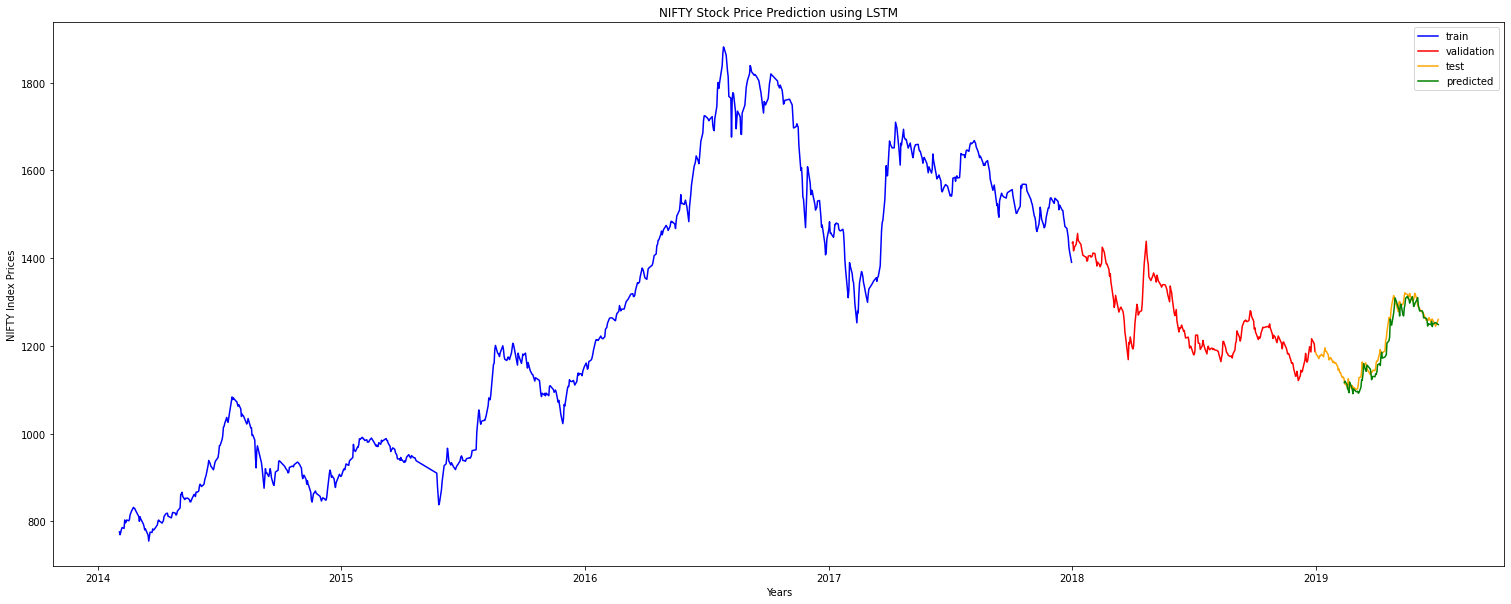

In [657]:
plt.figure(figsize=(26, 10))
plt.plot(train_df['date'], train_df['nepse'], color='blue', label="train")
plt.plot(validation_df['date'], validation_df['nepse'], color='red', label="validation")

plt.plot(test_df['date'],test_df['nepse'], color='orange', label='test')
plt.plot(test_df['date'].iloc[31:],predicted_stock_price, color='green', label='predicted')

plt.title('NIFTY Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('NIFTY Index Prices')
plt.legend()
plt.show()

In [658]:
from math import sqrt
from sklearn.metrics import mean_squared_error

RMSE_LSTM = sqrt(mean_squared_error(test_df.iloc[31:]['nepse'].values, predicted_stock_price))

print(f"RMSE_LSTM = {RMSE_LSTM}")

RMSE_LSTM = 18.89180454252489


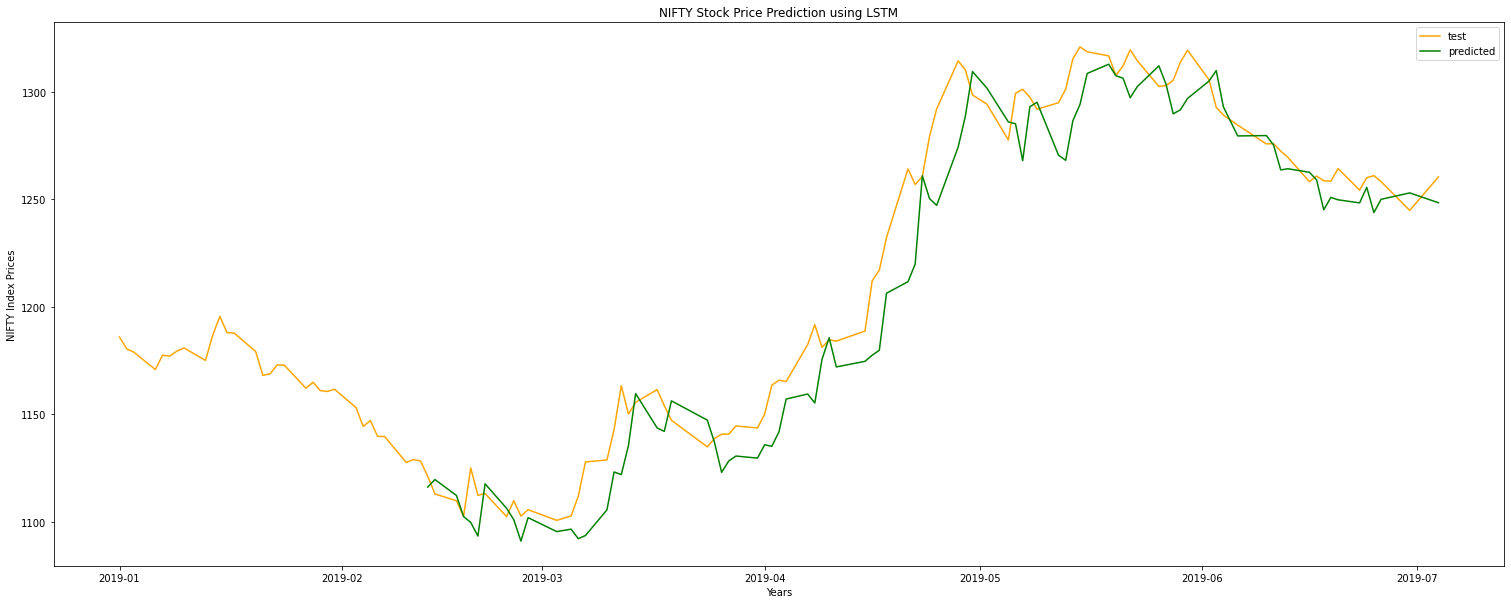

In [659]:
plt.figure(figsize=(26, 10))
plt.plot(test_df['date'],test_df['nepse'], color='orange', label='test')
plt.plot(test_df['date'].iloc[31:],predicted_stock_price, color='green', label='predicted')
plt.title('NIFTY Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('NIFTY Index Prices')
plt.legend()
plt.show()